In [191]:
import numpy as np               #for maths
import pandas as pd              #for data manipulation
import matplotlib.pyplot as plt  #for visualization

In [192]:
path = '/UsersDesktop/test_box_alpha.csv'
data = pd.read_csv(path)

#get names from the dataset
data['Name'] = data['Name']

#get first 10000 names
data = np.array(data['Name'][:200]).reshape(-1,1)

#covert the names to lowee case
data = [x.lower() for x in data[:,0]]

data = np.array(data).reshape(-1,1)

In [193]:
print("Data Shape = {}".format(data.shape))
print()
print("Lets see some names : ")
print(data[1:10])

Data Shape = (200, 1)

Lets see some names : 
[['fak']
 ['gajb']
 ['eag']
 ['faf']
 ['eafb']
 ['gab']
 ['dak']
 ['eak']
 ['eab']]


In [194]:
#to store the transform data
transform_data = np.copy(data)

#find the max length name
max_length = 0
for index in range(len(data)):
    max_length = max(max_length,len(data[index,0]))

#make every name of max length by adding '.'
for index in range(len(data)):
    length = (max_length - len(data[index,0]))
    string = '.'*length
    transform_data[index,0] = ''.join([transform_data[index,0],string])

In [195]:
print("Transformed Data")
print(transform_data[1:10])

Transformed Data
[['fak......']
 ['gajb.....']
 ['eag......']
 ['faf......']
 ['eafb.....']
 ['gab......']
 ['dak......']
 ['eak......']
 ['eab......']]


In [196]:
vocab = list()
for name in transform_data[:,0]:
    vocab.extend(list(name))

vocab = set(vocab)
vocab_size = len(vocab)

print("Vocab size = {}".format(len(vocab)))
print("Vocab      = {}".format(vocab))

Vocab size = 13
Vocab      = {'d', 'i', 'l', 'g', 'k', 'a', 'b', 'e', 'h', 'c', 'f', '.', 'j'}


In [197]:
char_id = dict()
id_char = dict()

for i,char in enumerate(vocab):
    char_id[char] = i
    id_char[i] = char



In [198]:
# list of batches of size = 20
train_dataset = []

batch_size = 20


for i in range(len(transform_data)-batch_size+1):
    start = i*batch_size
    end = start+batch_size
    
    #batch data
    batch_data = transform_data[start:end]
    
    if(len(batch_data)!=batch_size):
        break
        
    #convert each char of each name of batch data into one hot encoding
    char_list = []
    for k in range(len(batch_data[0][0])):
        batch_dataset = np.zeros([batch_size,len(vocab)])
        for j in range(batch_size):
            name = batch_data[j][0]
            char_index = char_id[name[k]]
            batch_dataset[j,char_index] = 1.0
     
        #store the ith char's one hot representation of each name in batch_data
        char_list.append(batch_dataset)
    
    #store each char's of every name in batch dataset into train_dataset
    train_dataset.append(char_list)

In [199]:
#number of input units or embedding size
input_units = 100

#number of hidden neurons
hidden_units = 256

#number of output units i.e vocab size
output_units = vocab_size

#learning rate
learning_rate = 0.005

#beta1 for V parameters used in Adam Optimizer
beta1 = 0.90

#beta2 for S parameters used in Adam Optimizer
beta2 = 0.99

In [200]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

#tanh activation
def tanh_activation(X):
    return np.tanh(X)

#softmax activation
def softmax(X):
    exp_X = np.exp(X)
    exp_X_sum = np.sum(exp_X,axis=1).reshape(-1,1)
    exp_X = exp_X/exp_X_sum
    return exp_X

#derivative of tanh
def tanh_derivative(X):
    return 1-(X**2)

In [201]:
def initialize_parameters():
    #initialize the parameters with 0 mean and 0.01 standard deviation
    mean = 0
    std = 0.01
    
    #lstm cell weights
    forget_gate_weights = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))
    input_gate_weights  = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))
    output_gate_weights = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))
    gate_gate_weights   = np.random.normal(mean,std,(input_units+hidden_units,hidden_units))
    
    #hidden to output weights (output cell)
    hidden_output_weights = np.random.normal(mean,std,(hidden_units,output_units))
    
    parameters = dict()
    parameters['fgw'] = forget_gate_weights
    parameters['igw'] = input_gate_weights
    parameters['ogw'] = output_gate_weights
    parameters['ggw'] = gate_gate_weights
    parameters['how'] = hidden_output_weights
    
    return parameters

In [202]:
def lstm_cell(batch_dataset, prev_activation_matrix, prev_cell_matrix, parameters):
    #get parameters
    fgw = parameters['fgw']
    igw = parameters['igw']
    ogw = parameters['ogw']
    ggw = parameters['ggw']
    
    #concat batch data and prev_activation matrix
    concat_dataset = np.concatenate((batch_dataset,prev_activation_matrix),axis=1)
    
    #forget gate activations
    fa = np.matmul(concat_dataset,fgw)
    fa = sigmoid(fa)
    
    #input gate activations
    ia = np.matmul(concat_dataset,igw)
    ia = sigmoid(ia)
    
    #output gate activations
    oa = np.matmul(concat_dataset,ogw)
    oa = sigmoid(oa)
    #print("Hello")
    
    #gate gate activations
    ga = np.matmul(concat_dataset,ggw)
    ga = tanh_activation(ga)
    
    #new cell memory matrix
    cell_memory_matrix = np.multiply(fa,prev_cell_matrix) + np.multiply(ia,ga)
    
    #current activation matrix
    activation_matrix = np.multiply(oa, tanh_activation(cell_memory_matrix))
    
    #lets store the activations to be used in back prop
    lstm_activations = dict()
    lstm_activations['fa'] = fa
    lstm_activations['ia'] = ia
    lstm_activations['oa'] = oa
    lstm_activations['ga'] = ga
    
    return lstm_activations,cell_memory_matrix,activation_matrix

In [203]:
def output_cell(activation_matrix,parameters):
    #get hidden to output parameters
    how = parameters['how']
    
    #get outputs 
    output_matrix = np.matmul(activation_matrix,how)
    output_matrix = softmax(output_matrix)
    
    return output_matrix

In [204]:
def get_embeddings(batch_dataset,embeddings):
    embedding_dataset = np.matmul(batch_dataset,embeddings)
    return embedding_dataset

In [205]:
#forward propagation
def forward_propagation(batches,parameters,embeddings):
    #get batch size
    batch_size = batches[0].shape[0]
    
    #to store the activations of all the unrollings.
    lstm_cache = dict()                 #lstm cache
    activation_cache = dict()           #activation cache 
    cell_cache = dict()                 #cell cache
    output_cache = dict()               #output cache
    embedding_cache = dict()            #embedding cache 
    
    #initial activation_matrix(a0) and cell_matrix(c0)
    a0 = np.zeros([batch_size,hidden_units],dtype=np.float32)
    c0 = np.zeros([batch_size,hidden_units],dtype=np.float32)
    
    #store the initial activations in cache
    activation_cache['a0'] = a0
    cell_cache['c0'] = c0
    
    #unroll the names
    for i in range(len(batches)-1):
        #get first first character batch
        batch_dataset = batches[i]
        
        #get embeddings 
        batch_dataset = get_embeddings(batch_dataset,embeddings)
        embedding_cache['emb'+str(i)] = batch_dataset
        
        #lstm cell
        lstm_activations,ct,at = lstm_cell(batch_dataset,a0,c0,parameters)
        
        #output cell
        ot = output_cell(at,parameters)
        
        #store the time 't' activations in caches
        lstm_cache['lstm' + str(i+1)]  = lstm_activations
        activation_cache['a'+str(i+1)] = at
        cell_cache['c' + str(i+1)] = ct
        output_cache['o'+str(i+1)] = ot
        
        #update a0 and c0 to new 'at' and 'ct' for next lstm cell
        a0 = at
        c0 = ct
        
    return embedding_cache,lstm_cache,activation_cache,cell_cache,output_cache

In [206]:
#calculate loss, perplexity and accuracy
def cal_loss_accuracy(batch_labels,output_cache):
    loss = 0  #to sum loss for each time step
    acc  = 0  #to sum acc for each time step 
    prob = 1  #probability product of each time step predicted char
    
    #batch size
    batch_size = batch_labels[0].shape[0]
    
    #loop through each time step
    for i in range(1,len(output_cache)+1):
        #get true labels and predictions
        labels = batch_labels[i]
        pred = output_cache['o'+str(i)]
        
        prob = np.multiply(prob,np.sum(np.multiply(labels,pred),axis=1).reshape(-1,1))
        loss += np.sum((np.multiply(labels,np.log(pred)) + np.multiply(1-labels,np.log(1-pred))),axis=1).reshape(-1,1)
        acc  += np.array(np.argmax(labels,1)==np.argmax(pred,1),dtype=np.float32).reshape(-1,1)
    
    #calculate perplexity loss and accuracy
    perplexity = np.sum((1/prob)**(1/len(output_cache)))/batch_size
    loss = np.sum(loss)*(-1/batch_size)
    acc  = np.sum(acc)/(batch_size)
    acc = acc/len(output_cache)
    
    return perplexity,loss,acc

In [207]:
#calculate output cell errors
def calculate_output_cell_error(batch_labels,output_cache,parameters):
    #to store the output errors for each time step
    output_error_cache = dict()
    activation_error_cache = dict()
    how = parameters['how']
    
    #loop through each time step
    for i in range(1,len(output_cache)+1):
        #get true and predicted labels
        labels = batch_labels[i]
        pred = output_cache['o'+str(i)]
        
        #calculate the output_error for time step 't'
        error_output = pred - labels
        
        #calculate the activation error for time step 't'
        error_activation = np.matmul(error_output,how.T)
        
        #store the output and activation error in dict
        output_error_cache['eo'+str(i)] = error_output
        activation_error_cache['ea'+str(i)] = error_activation
        
    return output_error_cache,activation_error_cache

In [208]:
#calculate error for single lstm cell
def calculate_single_lstm_cell_error(activation_output_error,next_activation_error,next_cell_error,parameters,lstm_activation,cell_activation,prev_cell_activation):
    #activation error =  error coming from output cell and error coming from the next lstm cell
    activation_error = activation_output_error + next_activation_error
    
    #output gate error
    oa = lstm_activation['oa']
    eo = np.multiply(activation_error,tanh_activation(cell_activation))
    eo = np.multiply(np.multiply(eo,oa),1-oa)
    
    #cell activation error
    cell_error = np.multiply(activation_error,oa)
    cell_error = np.multiply(cell_error,tanh_derivative(tanh_activation(cell_activation)))
    #error also coming from next lstm cell 
    cell_error += next_cell_error
    
    #input gate error
    ia = lstm_activation['ia']
    ga = lstm_activation['ga']
    ei = np.multiply(cell_error,ga)
    ei = np.multiply(np.multiply(ei,ia),1-ia)
    
    #gate gate error
    eg = np.multiply(cell_error,ia)
    eg = np.multiply(eg,tanh_derivative(ga))
    
    #forget gate error
    fa = lstm_activation['fa']
    ef = np.multiply(cell_error,prev_cell_activation)
    ef = np.multiply(np.multiply(ef,fa),1-fa)
    
    #prev cell error
    prev_cell_error = np.multiply(cell_error,fa)
    
    #get parameters
    fgw = parameters['fgw']
    igw = parameters['igw']
    ggw = parameters['ggw']
    ogw = parameters['ogw']
    
    #embedding + hidden activation error
    embed_activation_error = np.matmul(ef,fgw.T)
    embed_activation_error += np.matmul(ei,igw.T)
    embed_activation_error += np.matmul(eo,ogw.T)
    embed_activation_error += np.matmul(eg,ggw.T)
    
    input_hidden_units = fgw.shape[0]
    hidden_units = fgw.shape[1]
    input_units = input_hidden_units - hidden_units
    
    #prev activation error
    prev_activation_error = embed_activation_error[:,input_units:]
    
    #input error (embedding error)
    embed_error = embed_activation_error[:,:input_units]
    
    #store lstm error
    lstm_error = dict()
    lstm_error['ef'] = ef
    lstm_error['ei'] = ei
    lstm_error['eo'] = eo
    lstm_error['eg'] = eg
    
    return prev_activation_error,prev_cell_error,embed_error,lstm_error

In [209]:
#calculate output cell derivatives
def calculate_output_cell_derivatives(output_error_cache,activation_cache,parameters):
    #to store the sum of derivatives from each time step
    dhow = np.zeros(parameters['how'].shape)
    
    batch_size = activation_cache['a1'].shape[0]
    
    #loop through the time steps 
    for i in range(1,len(output_error_cache)+1):
        #get output error
        output_error = output_error_cache['eo' + str(i)]
        
        #get input activation
        activation = activation_cache['a'+str(i)]
        
        #cal derivative and summing up!
        dhow += np.matmul(activation.T,output_error)/batch_size
        
    return dhow

In [210]:
#calculate derivatives for single lstm cell
def calculate_single_lstm_cell_derivatives(lstm_error,embedding_matrix,activation_matrix):
    #get error for single time step
    ef = lstm_error['ef']
    ei = lstm_error['ei']
    eo = lstm_error['eo']
    eg = lstm_error['eg']
    
    #get input activations for this time step
    concat_matrix = np.concatenate((embedding_matrix,activation_matrix),axis=1)
    
    batch_size = embedding_matrix.shape[0]
    
    #cal derivatives for this time step
    dfgw = np.matmul(concat_matrix.T,ef)/batch_size
    digw = np.matmul(concat_matrix.T,ei)/batch_size
    dogw = np.matmul(concat_matrix.T,eo)/batch_size
    dggw = np.matmul(concat_matrix.T,eg)/batch_size
    
    #store the derivatives for this time step in dict
    derivatives = dict()
    derivatives['dfgw'] = dfgw
    derivatives['digw'] = digw
    derivatives['dogw'] = dogw
    derivatives['dggw'] = dggw
    
    return derivatives

In [211]:
#backpropagation
def backward_propagation(batch_labels,embedding_cache,lstm_cache,activation_cache,cell_cache,output_cache,parameters):
    #calculate output errors 
    output_error_cache,activation_error_cache = calculate_output_cell_error(batch_labels,output_cache,parameters)
    
    #to store lstm error for each time step
    lstm_error_cache = dict()
    
    #to store embeding errors for each time step
    embedding_error_cache = dict()
    
    # next activation error 
    # next cell error  
    #for last cell will be zero
    eat = np.zeros(activation_error_cache['ea1'].shape)
    ect = np.zeros(activation_error_cache['ea1'].shape)
    
    #calculate all lstm cell errors (going from last time-step to the first time step)
    for i in range(len(lstm_cache),0,-1):
        #calculate the lstm errors for this time step 't'
        pae,pce,ee,le = calculate_single_lstm_cell_error(activation_error_cache['ea'+str(i)],eat,ect,parameters,lstm_cache['lstm'+str(i)],cell_cache['c'+str(i)],cell_cache['c'+str(i-1)])
        
        #store the lstm error in dict
        lstm_error_cache['elstm'+str(i)] = le
        
        #store the embedding error in dict
        embedding_error_cache['eemb'+str(i-1)] = ee
        
        #update the next activation error and next cell error for previous cell
        eat = pae
        ect = pce
    
    
    #calculate output cell derivatives
    derivatives = dict()
    derivatives['dhow'] = calculate_output_cell_derivatives(output_error_cache,activation_cache,parameters)
    
    #calculate lstm cell derivatives for each time step and store in lstm_derivatives dict
    lstm_derivatives = dict()
    for i in range(1,len(lstm_error_cache)+1):
        lstm_derivatives['dlstm'+str(i)] = calculate_single_lstm_cell_derivatives(lstm_error_cache['elstm'+str(i)],embedding_cache['emb'+str(i-1)],activation_cache['a'+str(i-1)])
    
    #initialize the derivatives to zeros 
    derivatives['dfgw'] = np.zeros(parameters['fgw'].shape)
    derivatives['digw'] = np.zeros(parameters['igw'].shape)
    derivatives['dogw'] = np.zeros(parameters['ogw'].shape)
    derivatives['dggw'] = np.zeros(parameters['ggw'].shape)
    
    #sum up the derivatives for each time step
    for i in range(1,len(lstm_error_cache)+1):
        derivatives['dfgw'] += lstm_derivatives['dlstm'+str(i)]['dfgw']
        derivatives['digw'] += lstm_derivatives['dlstm'+str(i)]['digw']
        derivatives['dogw'] += lstm_derivatives['dlstm'+str(i)]['dogw']
        derivatives['dggw'] += lstm_derivatives['dlstm'+str(i)]['dggw']
    
    return derivatives,embedding_error_cache

In [212]:
def update_parameters(parameters,derivatives,V,S,t):
    #get derivatives
    dfgw = derivatives['dfgw']
    digw = derivatives['digw']
    dogw = derivatives['dogw']
    dggw = derivatives['dggw']
    dhow = derivatives['dhow']
    
    #get parameters
    fgw = parameters['fgw']
    igw = parameters['igw']
    ogw = parameters['ogw']
    ggw = parameters['ggw']
    how = parameters['how']
    
    #get V parameters
    vfgw = V['vfgw']
    vigw = V['vigw']
    vogw = V['vogw']
    vggw = V['vggw']
    vhow = V['vhow']
    
    #get S parameters
    sfgw = S['sfgw']
    sigw = S['sigw']
    sogw = S['sogw']
    sggw = S['sggw']
    show = S['show']
    
    #calculate the V parameters from V and current derivatives
    vfgw = (beta1*vfgw + (1-beta1)*dfgw)
    vigw = (beta1*vigw + (1-beta1)*digw)
    vogw = (beta1*vogw + (1-beta1)*dogw)
    vggw = (beta1*vggw + (1-beta1)*dggw)
    vhow = (beta1*vhow + (1-beta1)*dhow)
    
    #calculate the S parameters from S and current derivatives
    sfgw = (beta2*sfgw + (1-beta2)*(dfgw**2))
    sigw = (beta2*sigw + (1-beta2)*(digw**2))
    sogw = (beta2*sogw + (1-beta2)*(dogw**2))
    sggw = (beta2*sggw + (1-beta2)*(dggw**2))
    show = (beta2*show + (1-beta2)*(dhow**2))
    
    #update the parameters
    fgw = fgw - learning_rate*((vfgw)/(np.sqrt(sfgw) + 1e-6))
    igw = igw - learning_rate*((vigw)/(np.sqrt(sigw) + 1e-6))
    ogw = ogw - learning_rate*((vogw)/(np.sqrt(sogw) + 1e-6))
    ggw = ggw - learning_rate*((vggw)/(np.sqrt(sggw) + 1e-6))
    how = how - learning_rate*((vhow)/(np.sqrt(show) + 1e-6))
    
    #store the new weights
    parameters['fgw'] = fgw
    parameters['igw'] = igw
    parameters['ogw'] = ogw
    parameters['ggw'] = ggw
    parameters['how'] = how
    
    #store the new V parameters
    V['vfgw'] = vfgw 
    V['vigw'] = vigw 
    V['vogw'] = vogw 
    V['vggw'] = vggw
    V['vhow'] = vhow
    
    #store the s parameters
    S['sfgw'] = sfgw 
    S['sigw'] = sigw 
    S['sogw'] = sogw 
    S['sggw'] = sggw
    S['show'] = show
    
    return parameters,V,S    

In [213]:
#update the Embeddings
def update_embeddings(embeddings,embedding_error_cache,batch_labels):
    #to store the embeddings derivatives
    embedding_derivatives = np.zeros(embeddings.shape)
    
    batch_size = batch_labels[0].shape[0]
    
    #sum the embedding derivatives for each time step
    for i in range(len(embedding_error_cache)):
        embedding_derivatives += np.matmul(batch_labels[i].T,embedding_error_cache['eemb'+str(i)])/batch_size
    
    #update the embeddings
    embeddings = embeddings - learning_rate*embedding_derivatives
    return embeddings

In [214]:
def initialize_V(parameters):
    Vfgw = np.zeros(parameters['fgw'].shape)
    Vigw = np.zeros(parameters['igw'].shape)
    Vogw = np.zeros(parameters['ogw'].shape)
    Vggw = np.zeros(parameters['ggw'].shape)
    Vhow = np.zeros(parameters['how'].shape)
    
    V = dict()
    V['vfgw'] = Vfgw
    V['vigw'] = Vigw
    V['vogw'] = Vogw
    V['vggw'] = Vggw
    V['vhow'] = Vhow
    return V

def initialize_S(parameters):
    Sfgw = np.zeros(parameters['fgw'].shape)
    Sigw = np.zeros(parameters['igw'].shape)
    Sogw = np.zeros(parameters['ogw'].shape)
    Sggw = np.zeros(parameters['ggw'].shape)
    Show = np.zeros(parameters['how'].shape)
    
    S = dict()
    S['sfgw'] = Sfgw
    S['sigw'] = Sigw
    S['sogw'] = Sogw
    S['sggw'] = Sggw
    S['show'] = Show
    return S

In [215]:
#train function
def train(train_dataset,iters=1000,batch_size=20):
    #initalize the parameters
    parameters = initialize_parameters()
    
    #initialize the V and S parameters for Adam
    V = initialize_V(parameters)
    S = initialize_S(parameters)
    
    #generate the random embeddings
    embeddings = np.random.normal(0,0.01,(len(vocab),input_units))
    
    #to store the Loss, Perplexity and Accuracy for each batch
    J = []
    P = []
    A = []
    
    
    for step in range(iters):
        #get batch dataset
        index = step%len(train_dataset)
        batches = train_dataset[index]
        
        #forward propagation
        embedding_cache,lstm_cache,activation_cache,cell_cache,output_cache = forward_propagation(
            batches,parameters,embeddings)
        
        #calculate the loss, perplexity and accuracy
        perplexity,loss,acc = cal_loss_accuracy(batches,output_cache)
        
        #backward propagation
        derivatives,embedding_error_cache = backward_propagation(batches,embedding_cache,lstm_cache,
                                            activation_cache,cell_cache,output_cache,parameters)
        
        #update the parameters
        parameters,V,S = update_parameters(parameters,derivatives,V,S,step)
        
        #update the embeddings
        embeddings = update_embeddings(embeddings,embedding_error_cache,batches)
        
        
        J.append(loss)
        P.append(perplexity)
        A.append(acc)
        
        #print loss, accuracy and perplexity
        if(step%1000==0):
            print("For Single Batch :")
            print('Step       = {}'.format(step))
            print('Loss       = {}'.format(round(loss,2)))
            print('Perplexity = {}'.format(round(perplexity,2)))
            print('Accuracy   = {}'.format(round(acc*100,2)))
            print()
    
    return embeddings, parameters,J,P,A

In [216]:
embeddings,parameters,J,P,A = train(train_dataset,iters=8001)

For Single Batch :
Step       = 0
Loss       = 28.2
Perplexity = 13.0
Accuracy   = 3.12

For Single Batch :
Step       = 1000
Loss       = 4.23
Perplexity = 1.4
Accuracy   = 85.62

For Single Batch :
Step       = 2000
Loss       = 4.09
Perplexity = 1.38
Accuracy   = 86.25

For Single Batch :
Step       = 3000
Loss       = 4.07
Perplexity = 1.38
Accuracy   = 85.62

For Single Batch :
Step       = 4000
Loss       = 4.05
Perplexity = 1.38
Accuracy   = 85.62

For Single Batch :
Step       = 5000
Loss       = 4.05
Perplexity = 1.38
Accuracy   = 85.62

For Single Batch :
Step       = 6000
Loss       = 4.04
Perplexity = 1.38
Accuracy   = 85.62

For Single Batch :
Step       = 7000
Loss       = 4.04
Perplexity = 1.38
Accuracy   = 85.62

For Single Batch :
Step       = 8000
Loss       = 4.03
Perplexity = 1.38
Accuracy   = 85.62



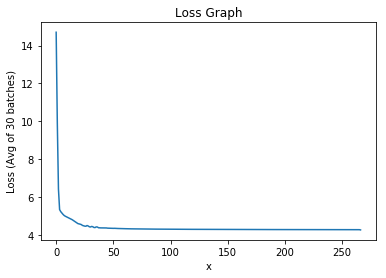

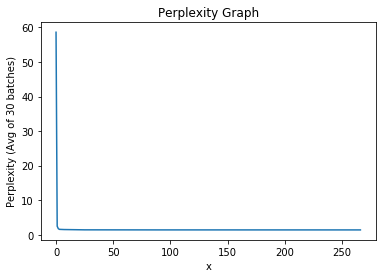

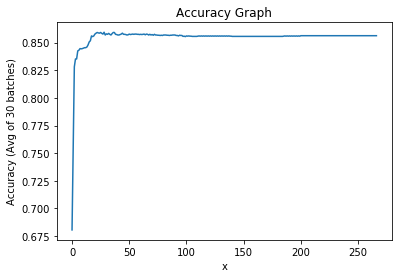

In [217]:
avg_loss = list()
avg_acc = list()
avg_perp = list()
i = 0
while(i<len(J)):
    avg_loss.append(np.mean(J[i:i+30]))
    avg_acc.append(np.mean(A[i:i+30]))
    avg_perp.append(np.mean(P[i:i+30]))
    i += 30

plt.plot(list(range(len(avg_loss))),avg_loss)
plt.xlabel("x")
plt.ylabel("Loss (Avg of 30 batches)")
plt.title("Loss Graph")
plt.show()

plt.plot(list(range(len(avg_perp))),avg_perp)
plt.xlabel("x")
plt.ylabel("Perplexity (Avg of 30 batches)")
plt.title("Perplexity Graph")
plt.show()

plt.plot(list(range(len(avg_acc))),avg_acc)
plt.xlabel("x")
plt.ylabel("Accuracy (Avg of 30 batches)")
plt.title("Accuracy Graph")
plt.show()    

In [221]:
#predict
def predict(parameters,embeddings,id_char,vocab_size):
    #to store some predicted names
    names = []
    
    #predict 20 names
    for i in range(20):
        #initial activation_matrix(a0) and cell_matrix(c0)
        a0 = np.zeros([1,hidden_units],dtype=np.float32)
        c0 = np.zeros([1,hidden_units],dtype=np.float32)

        #initalize blank name
        name = ''
        
        #make a batch dataset of single char
        batch_dataset = np.zeros([1,vocab_size])
        
        #get random start character
        index = np.random.randint(0,13,1)[0]
        
        #make that index 1.0
        batch_dataset[0,index] = 1.0
        
        #add first char to name
        name += id_char[index]
        
        #get char from id_char dict
        char = id_char[index]
        
        #loop until algo predicts '.'
        while(char!='.'):
            #get embeddings
            batch_dataset = get_embeddings(batch_dataset,embeddings)

            #lstm cell
            lstm_activations,ct,at = lstm_cell(batch_dataset,a0,c0,parameters)

            #output cell
            ot = output_cell(at,parameters)
            
            #either select random.choice ot np.argmax
            pred = np.random.choice(13,1,p=ot[0])[0]
            
            #get predicted char index
            #pred = np.argmax(ot)
                
            #add char to name
            name += id_char[pred]
            
            char = id_char[pred]
            
            #change the batch_dataset to this new predicted char
            batch_dataset = np.zeros([1,vocab_size])
            batch_dataset[0,pred] = 1.0

            #update a0 and c0 to new 'at' and 'ct' for next lstm cell
            a0 = at
            c0 = ct
            
        #append the predicted name to names list
        names.append(name)
        
    return names

In [222]:
predict(parameters,embeddings,id_char,vocab_size)


['c.',
 '.',
 'eab.',
 'fak.',
 'hae.',
 '.',
 'kag.',
 'fad.',
 'eag.',
 'gab.',
 'lk.',
 'chajb.',
 'jiab.',
 '.',
 'bbbbbb.',
 'lh.',
 '.',
 'cjhlgaj.',
 'kajbb.',
 'gab.']

In [223]:
predict(parameters,embeddings,id_char,vocab_size)

['.',
 'kab.',
 'kag.',
 'chae.',
 'l.',
 'bb.',
 'ibb.',
 'ceahbbb.',
 'dag.',
 'bbb.',
 'jhah.',
 'faibb.',
 '.',
 'dah.',
 'daj.',
 'bbb.',
 'fag.',
 'cbag.',
 'dai.',
 'gab.']